# Voting History

## Python setup

In [1]:
# data science imports
import pathlib

# system imports
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

In [2]:
# local imports
import common
import plotting
from common import COLOR_COALITION, COLOR_LABOR

In [3]:
# plotting stuff
plt.style.use("fivethirtyeight")
SHOW = True

## Data

In [4]:
HISTORY = "../historic-data/election-outcomes.csv"
table = pd.read_csv(
    HISTORY,
    header=0,
    index_col=0,
    delim_whitespace=True,
    comment="#",
    na_values="-",
    parse_dates=["Date"],
)

In [5]:
coalition = ["LP", "LNP", "NP", "CLP"]
e_others = ["DLP", "DEM", "GRN", "ON", "UAP", "Others"]
primary = ["ALP", "LP", "LNP", "NP", "CLP", "DLP", "DEM", "GRN", "ON", "UAP", "Others"]

In [6]:
# quick data consistency checks
assert table.index.is_monotonic_increasing
row_sums = table[primary].sum(axis=1, skipna=True)
assert (row_sums >= 99.8).all() and (row_sums <= 100.2).all()
assert (table["ALP"] < table["Labor2pp"]).all()
assert len(table["GovtBefore"].unique()) == 2
assert len(table["GovtAfter"].unique()) == 2
assert (table["Date"].dt.year == table.index).all()

## Historical plots

### Minor parties

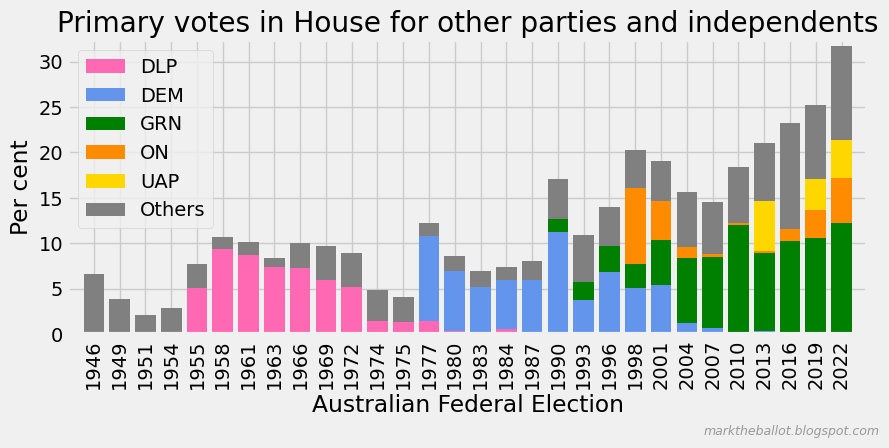

In [7]:
fig, ax = plotting.initiate_plot()
table[e_others].plot.bar(
    stacked=True,
    ax=ax,
    width=0.8,
    color=["hotpink", "cornflowerblue", "green", "darkorange", "gold", "grey"],
)
plotting.finalise_plot(
    ax,
    title="Primary votes in House for other parties and independents",
    xlabel="Australian Federal Election",
    ylabel="Per cent",
    rfooter=plotting.RFOOTER,
    show=SHOW,
)

### Mainstream parties

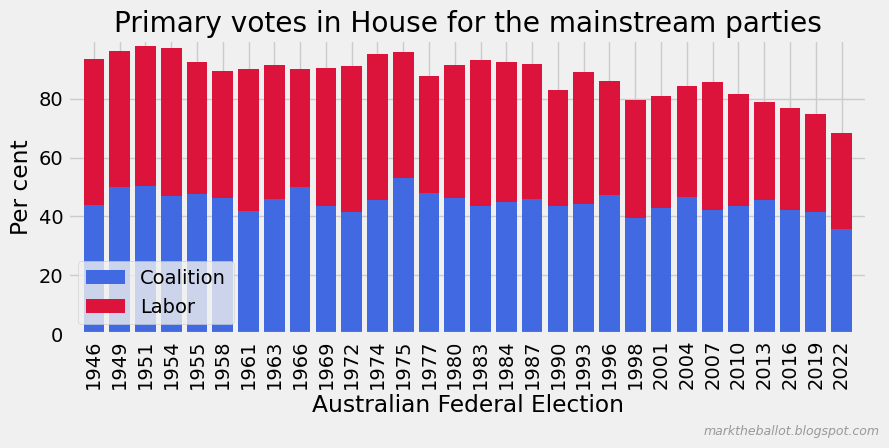

In [8]:
mainstream = table.copy()
mainstream["Coalition"] = mainstream[coalition].sum(axis=1)
mainstream = mainstream.rename(columns={"ALP": "Labor"})
majors = ["Coalition", "Labor"]
fig, ax = plotting.initiate_plot()
mainstream[majors].plot.bar(
    stacked=True, ax=ax, width=0.8, color=[COLOR_COALITION, COLOR_LABOR]
)
plotting.finalise_plot(
    ax,
    title="Primary votes in House for the mainstream parties",
    xlabel="Australian Federal Election",
    ylabel="Per cent",
    rfooter=plotting.RFOOTER,
    legend={"loc": "lower left"},
    show=SHOW,
)

### Election cycles

In [9]:
def add_government(from_table, start, ending, to_cycles, colors, markers):
    name = f"{start}-{ending}"
    selection = from_table.index[
        (from_table.index >= start) & (from_table.index <= ending)
    ]
    dates = from_table.loc[selection].Date
    values = from_table.loc[selection].Labor2pp
    if from_table.at[start, "GovtAfter"] == "Coalition":
        values = 100 - values
        colors[name] = COLOR_COALITION
        markers[name] = MARKER_COALITION
    else:
        colors[name] = COLOR_LABOR
        markers[name] = MARKER_LABOR
    values.index = dates
    to_cycles[name] = values

In [10]:
# identify changes of government at an election ...
changes = table["GovtBefore"] != table["GovtAfter"]
change_points = changes[changes].index.values
final = table.index[-1]
if final not in change_points:
    change_points = np.append(change_points, table.index[-1])


# construct separate runs for each government
MARKER_LABOR, MARKER_COALITION = "o", "s"
cycles = pd.DataFrame(index=table.Date)
colors = {}
markers = {}

start = table.index[0]
for ending in change_points:
    add_government(table, start, ending, cycles, colors, markers)
    start = ending

# special case - newly elected government
if table.index[-1] in change_points:
    add_government(table, start, ending, cycles, colors, markers)

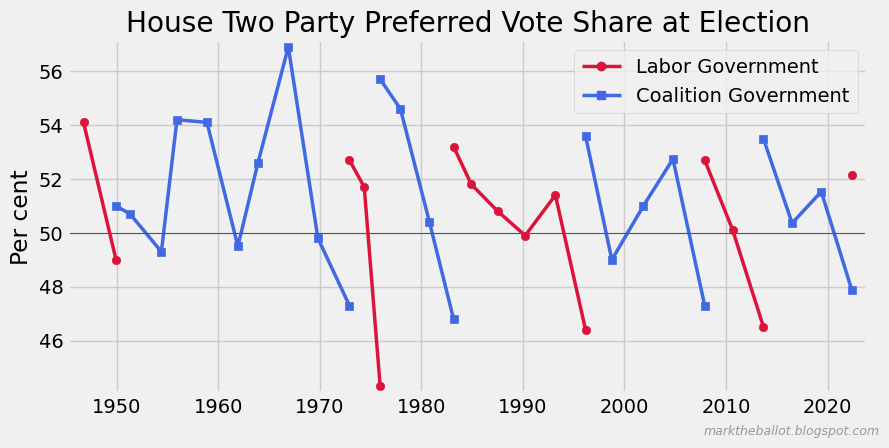

In [11]:
# plot these government cycles
LW = 2.5
fig, ax = plotting.initiate_plot()
for column in cycles.columns:
    cycles[column].plot.line(ax=ax, c=colors[column], linewidth=LW)
    ax.scatter(
        cycles.index, cycles[column], marker=markers[column], color=colors[column]
    )

# custom legend
custom_lines = [
    Line2D([0], [0], color=COLOR_LABOR, lw=LW, marker=MARKER_LABOR),
    Line2D([0], [0], color=COLOR_COALITION, lw=LW, marker=MARKER_COALITION),
]
ax.legend(custom_lines, ["Labor Government", "Coalition Government"])

# finalise plot
plotting.finalise_plot(
    ax,
    xlabel=None,
    ylabel="Per cent",
    rfooter=plotting.RFOOTER,
    title="House Two Party Preferred Vote Share at Election",
    concise_dates=True,
    straighten_tl=True,
    y50=True,
    show=SHOW,
)

## The End

In [12]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun Nov 12 2023 12:02:41

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

numpy     : 1.25.2
pandas    : 2.1.3
matplotlib: 3.8.1

Watermark: 2.4.3



In [13]:
print("It is done")

It is done
